In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from darts import concatenate

from darts.models import NaiveDrift, TCNModel, NBEATSModel, TFTModel, RegressionModel
from darts.dataprocessing.transformers import Scaler, Diff
from darts import TimeSeries
from darts.metrics import rmse
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from torch.nn import MSELoss

import optuna
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
    plot_param_importances,
)


plt.rcParams.update({'figure.figsize':(18,10), 'figure.dpi':120})

#print(tf.__version__)
#print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

/Users/andreypak/opt/miniconda3/envs/electro2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv(r'electricityDailyLoad.csv')
df['dt'] = pd.to_datetime(df['dt'])
df.sort_values(by='dt', inplace=True)
df.drop_duplicates(subset=["dt"], keep='first', inplace=True)

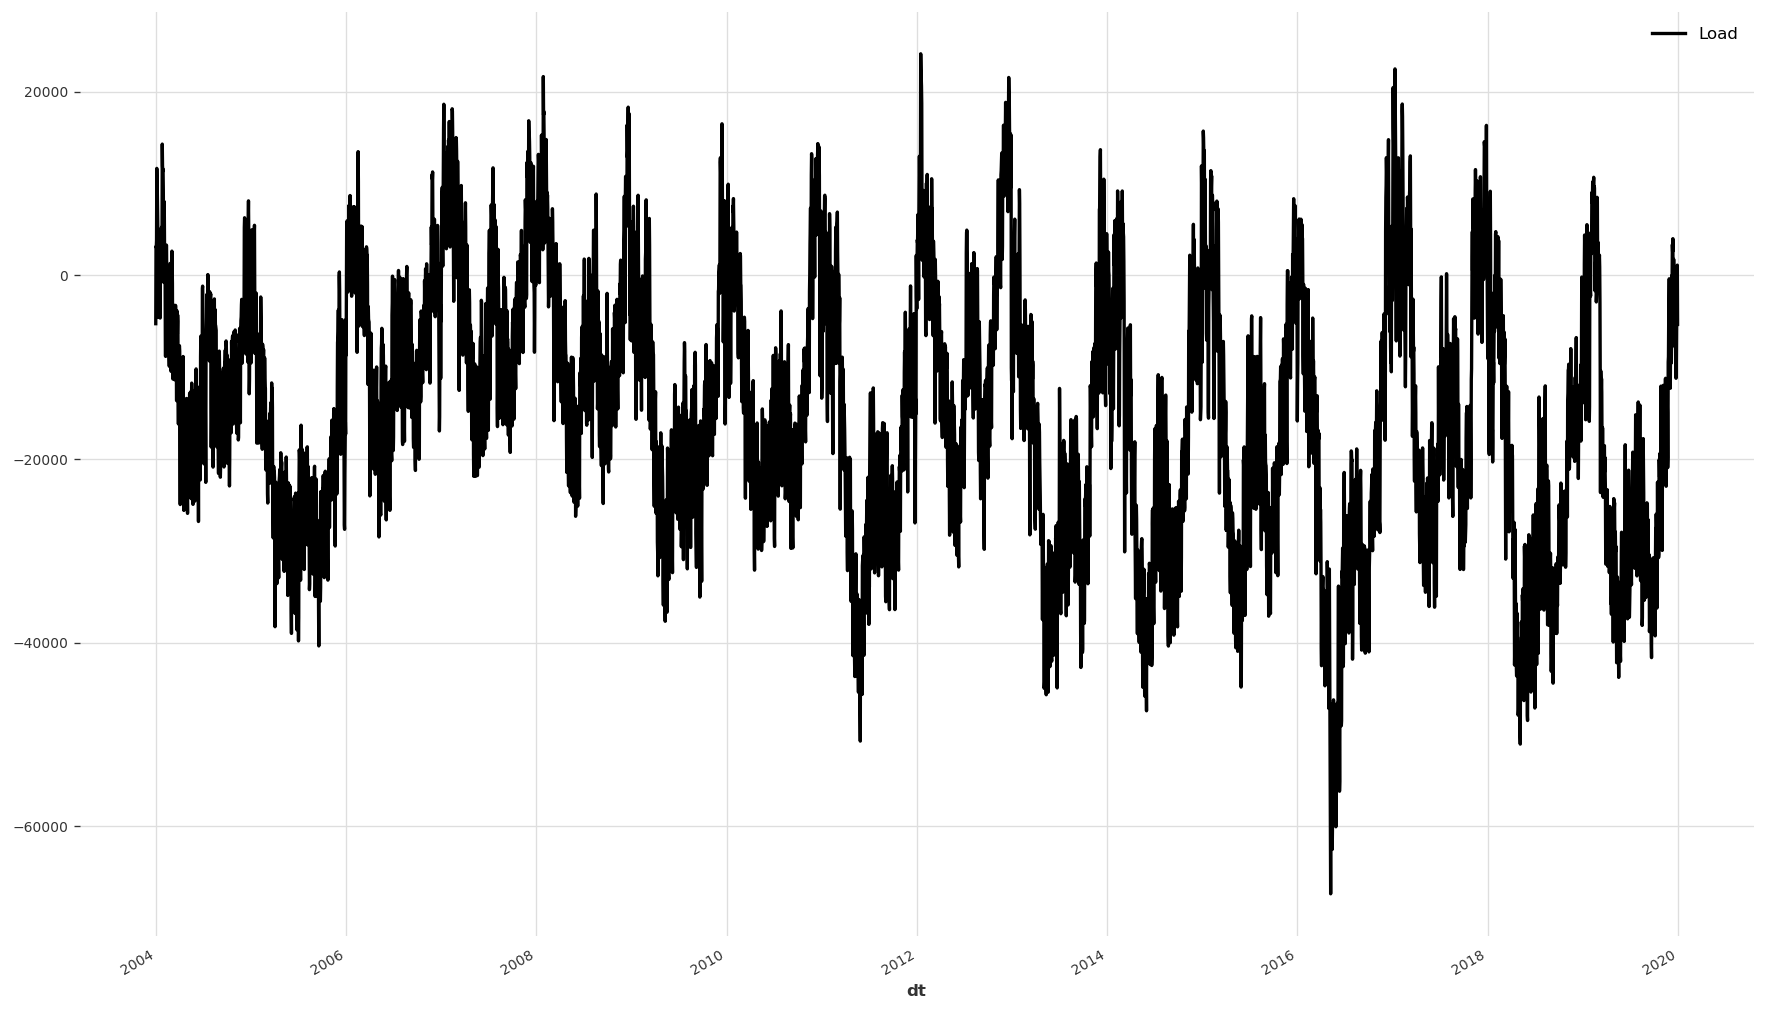

In [5]:
series1 = TimeSeries.from_dataframe(df, "dt","Load")
series = series1.astype(np.float32)

train_val, test = series.split_before(pd.Timestamp("20190101"))

Regression = NaiveDrift()
Regression.fit(train_val)
trend = Regression.historical_forecasts(series, start=pd.Timestamp("20040101"), train_length=365*4, forecast_horizon=365, stride=365, retrain=True, 
overlap_end=True, last_points_only=False, verbose=False)
trend = concatenate(trend)
#trend.plot(label="forecast")

series=series[pd.Timestamp("20040101"):]-trend[:pd.Timestamp("20191231")]
series.plot()

train_val, _ = series.split_before(pd.Timestamp("20190101"))
train, val = train_val.split_before(pd.Timestamp("20180101"))

scaler_ = StandardScaler()
scaler = Scaler(scaler_)

train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)

train_val_scaled = scaler.transform(train_val)
#test_scaled = scaler.transform(test)

series_scaled = scaler.transform(series)
#series_scaled.plot()

In [6]:
year_series = TimeSeries.from_times_and_values(
                                                times=series1.time_index,
                                                values=np.arange(len(series1)),
                                                columns=["linear_increase"],
                                            )

day_series = datetime_attribute_timeseries(
    year_series, attribute="dayofyear", one_hot=True
)

weekday_series = datetime_attribute_timeseries(
    year_series, attribute="dayofweek", one_hot=True
)

covariates = year_series.stack(day_series)
covariates = covariates.stack(weekday_series)
# covariates = day_series.stack(weekday_series)
covariates = covariates.astype(np.float32)

covariates_scaled = Scaler(scaler_).fit_transform(covariates)
#covariates.plot()

To judge how well our models perform, we will make 12 consequent non-overlaping 30-day ahead forecasts starting from 2019-01-01.

In [7]:
def eval_results(model, past_covariates, future_covariates):
    backtest = model.historical_forecasts(
        series_scaled,
        past_covariates=past_covariates,
        future_covariates=future_covariates,
        start=pd.Timestamp("20190101"),
        forecast_horizon=30,
        stride=30,
        last_points_only = False,
        retrain=False,
        verbose=False,
    )
    forecast = concatenate(backtest)
    forecast = scaler.inverse_transform(forecast)
    forecast = forecast+trend[pd.Timestamp("20190101"):pd.Timestamp("20191226")]
    fig1 = forecast.plot(label="forecast")
    fig2 = test.plot()

    error=[]
    for i in range(0,12):
        e = rmse(forecast[i*30:i*30+30], test[i*30:i*30+30], verbose=False)
        error.append(e)

    average_error = np.mean(error)
    print("Average error (RMSE) over all historical forecasts: %.2f" % average_error)    

In [8]:
def eval_results_tune(model):
    backtest = model.historical_forecasts(
        train_val_scaled,
        past_covariates=covariates_scaled,
        #future_covariates=covariates_scaled,
        start=pd.Timestamp("20180101"),
        forecast_horizon=30,
        stride=30,
        last_points_only = False,
        retrain=False,
        verbose=False
    )
    forecast = concatenate(backtest)
    forecast = scaler.inverse_transform(forecast)
    #forecast.plot(label="forecast")
    #val.plot()
    error=[]
    for i in range(0,12):
        error.append(rmse(forecast[i*30:i*30+30], val[i*30:i*30+30], verbose=False))

    return np.mean(error)

In [9]:
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=2,
    min_delta=0.001,
)

deeptcn = TCNModel(
    input_chunk_length=30,
    output_chunk_length=7,
    batch_size=64,
    n_epochs=40,
    optimizer_kwargs={"lr": 1e-3},
    random_state=0,
    kernel_size=5,
    num_filters=5,
    dilation_base=2,
    force_reset=True,
    pl_trainer_kwargs= {"accelerator": "mps", "devices": 1, "callbacks": [my_stopper]}
)

deeptcn.fit(series=train_scaled,                  
            past_covariates=covariates_scaled,
            val_series=val_scaled,
            val_past_covariates=covariates_scaled,
            verbose=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 11.8 K
----------------------------------------------------
11.8 K    Trainable params
0         Non-trainable params
11.8 K    Total params
0.047     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 80/80 [00:01<00:00, 56.27it/s, train_loss=0.105, val_loss=0.197] 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/andreypak/opt/miniconda3/envs/electro2/lib/python3.9/site-packages/darts/models/forecasting/pl_forecasting_module.py:480: UserWarning: The operator 'aten::roll' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1678454847243/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  input_past = torch.roll(input_past, -roll_size, 1)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0

Average error (RMSE) over all historical forecasts: 5723.28


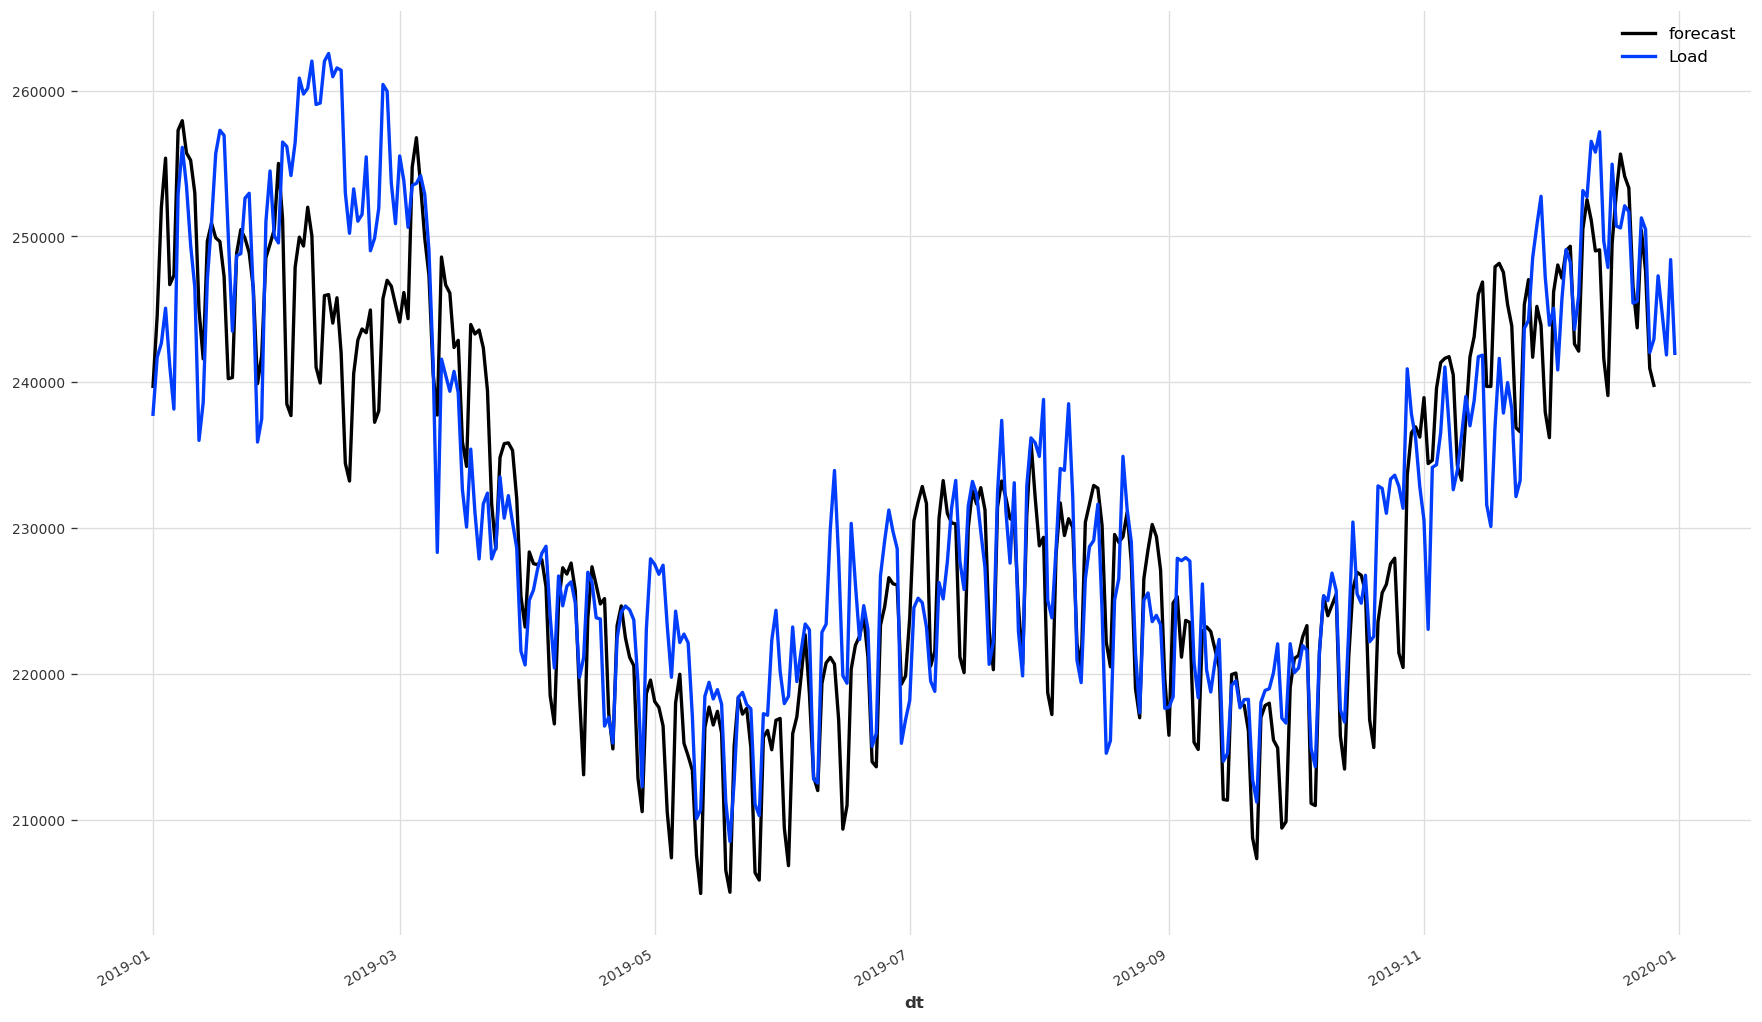

In [10]:
eval_results(deeptcn, past_covariates=covariates_scaled, future_covariates=None)

In [11]:
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=2,
)

model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=30,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name="nbeats_run",
    force_reset=True,
    random_state=5,
    optimizer_kwargs={"lr": 5e-5},
    pl_trainer_kwargs= {"callbacks": [my_stopper]}
)

model_nbeats.fit(train_scaled,     
                 past_covariates=covariates_scaled,
                 val_series=val_scaled,
                 val_past_covariates=covariates_scaled, 
                 verbose=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 66.7 M
---------------------------------------------------
66.7 M    Trainable params
69.9 K    Non-trainable params
66.7 M    Total params
266.916   Total estimated model params size (MB)


Epoch 13: 100%|██████████| 7/7 [00:02<00:00,  2.67it/s, train_loss=0.215, val_loss=0.312]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: 

Average error (RMSE) over all historical forecasts: 5830.86


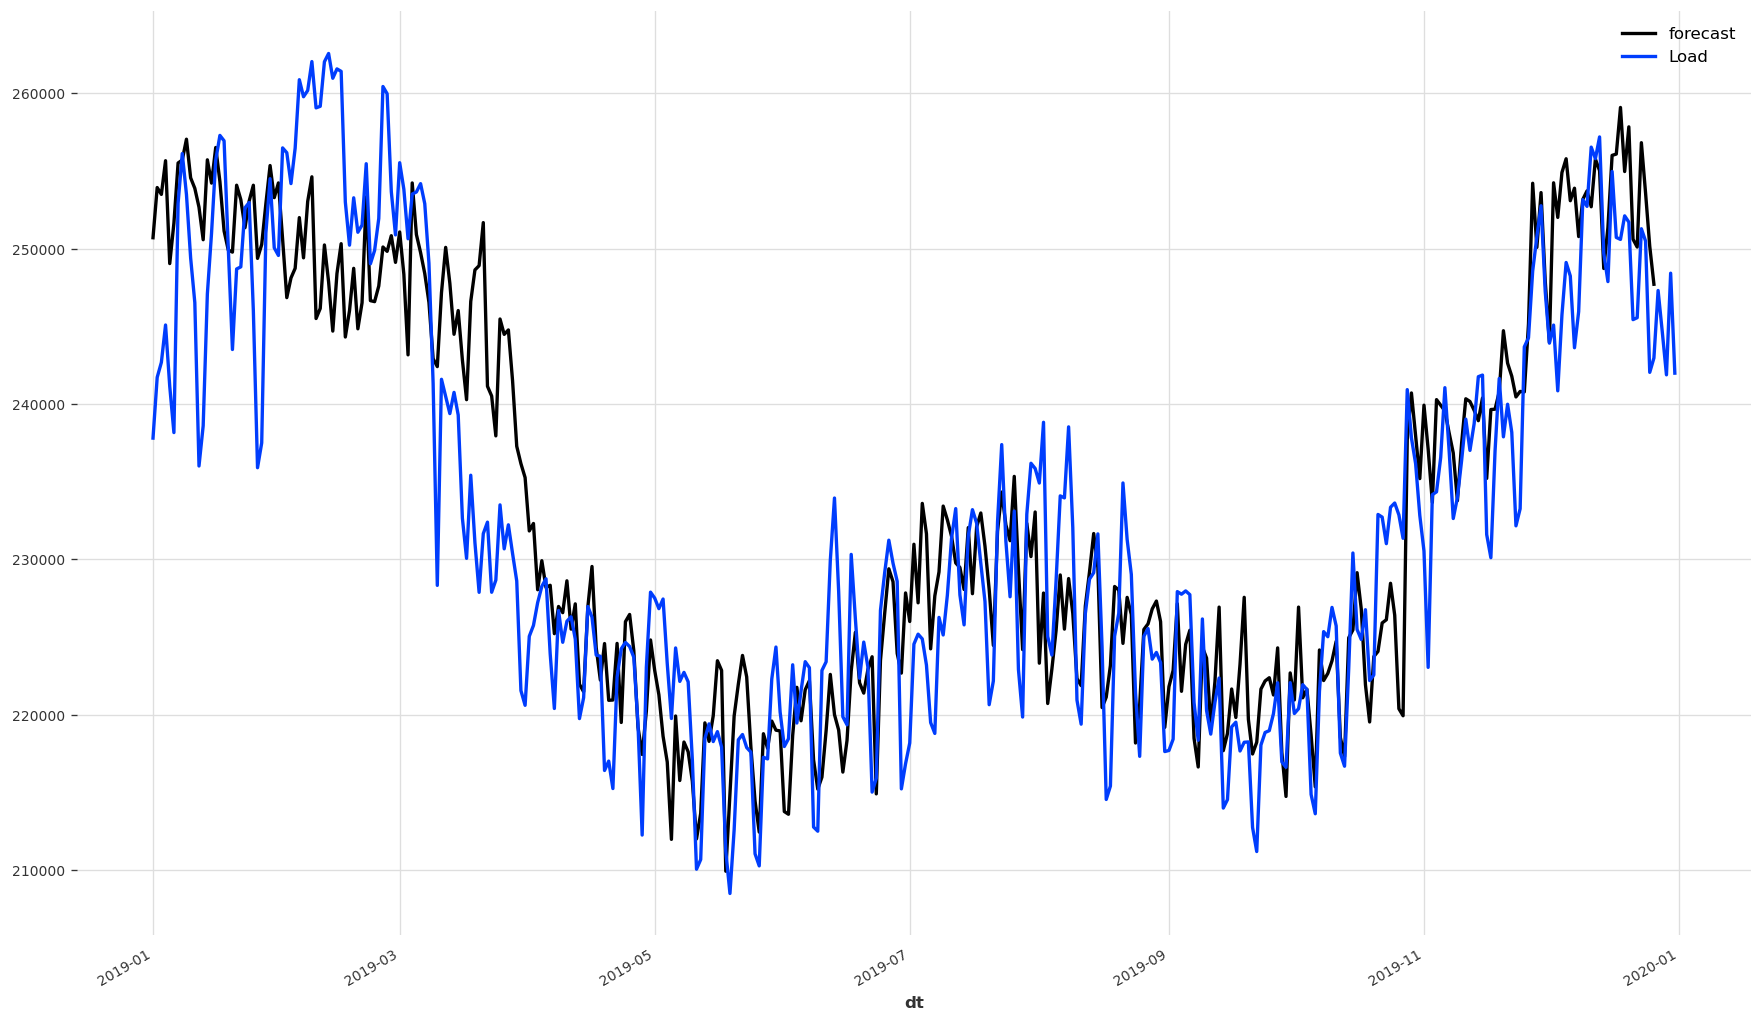

In [12]:
eval_results(model_nbeats, past_covariates=covariates_scaled, future_covariates=None)

In [257]:
def objective_tcn(trial):
    early_stopper = EarlyStopping("val_loss", patience=2, verbose=False)

    in_len = trial.suggest_int("in_len", 8, 120)
    #out_len = trial.suggest_int("out_len", 1, min(30, in_len-1))
    # Other hyperparameters
    #hidden_size = trial.suggest_int("hidden_size", 1, 1024)
    #dropout = trial.suggest_float("dropout", 0.0, 0.3)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    #num_filters = trial.suggest_int("num_filters", 1, 50)

    model = TCNModel(
    input_chunk_length=in_len,
    output_chunk_length=7,
    batch_size=64,
    n_epochs=100,
    optimizer_kwargs={"lr": lr},
    random_state=0,
    kernel_size=5,
    num_filters=5,
    dilation_base=2,
    force_reset=True,
    model_name="tcn",
    save_checkpoints=True,
    pl_trainer_kwargs= {"accelerator": "mps", "devices": 1, "callbacks": [my_stopper]}
)

    # train the model
    model.fit(train_scaled, 
        past_covariates=covariates_scaled,
        val_series=val_scaled,
        val_past_covariates=covariates_scaled, 
        verbose=False)
    # reload best model over course of training
    model = TCNModel.load_from_checkpoint("tcn")
    

    return eval_results_tune(model)

In [258]:
study_tcn = optuna.create_study(direction="minimize")

study_tcn.optimize(objective_tcn, n_trials=100)

# Finally, print the best value and best hyperparameters:
print(f"Best value: {study_tcn.best_value}, Best params: {study_tcn.best_trial.params}")

[I 2023-04-22 17:56:36,848] A new study created in memory with name: no-name-eaa205ca-2e69-4ece-8cbf-af36e1ece40b
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: F

Best value: 6460.484375, Best params: {'in_len': 76, 'lr': 0.005979230760131751}


In [259]:
plot_contour(study_tcn, params=['in_len',  'lr'])

In [254]:
plot_param_importances(study_tcn)

In [13]:
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=2,
    min_delta=0.001,
)

deeptcn = TCNModel(
    input_chunk_length=76,
    output_chunk_length=7,
    batch_size=64,
    n_epochs=40,
    optimizer_kwargs={"lr": 0.05},
    random_state=3,
    kernel_size=5,
    num_filters=5,
    dilation_base=2,
    force_reset=True,
    pl_trainer_kwargs= {"accelerator": "mps", "devices": 1, "callbacks": [my_stopper]}
)

deeptcn.fit(series=train_scaled,                  
            past_covariates=covariates_scaled,
            val_series=val_scaled,
            val_past_covariates=covariates_scaled,
            verbose=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 12.0 K
----------------------------------------------------
12.0 K    Trainable params
0         Non-trainable params
12.0 K    Total params
0.048     Total estimated model params size (MB)


Epoch 2: 100%|██████████| 79/79 [00:01<00:00, 46.10it/s, train_loss=0.120, val_loss=0.209]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: 

Average error (RMSE) over all historical forecasts: 5577.30


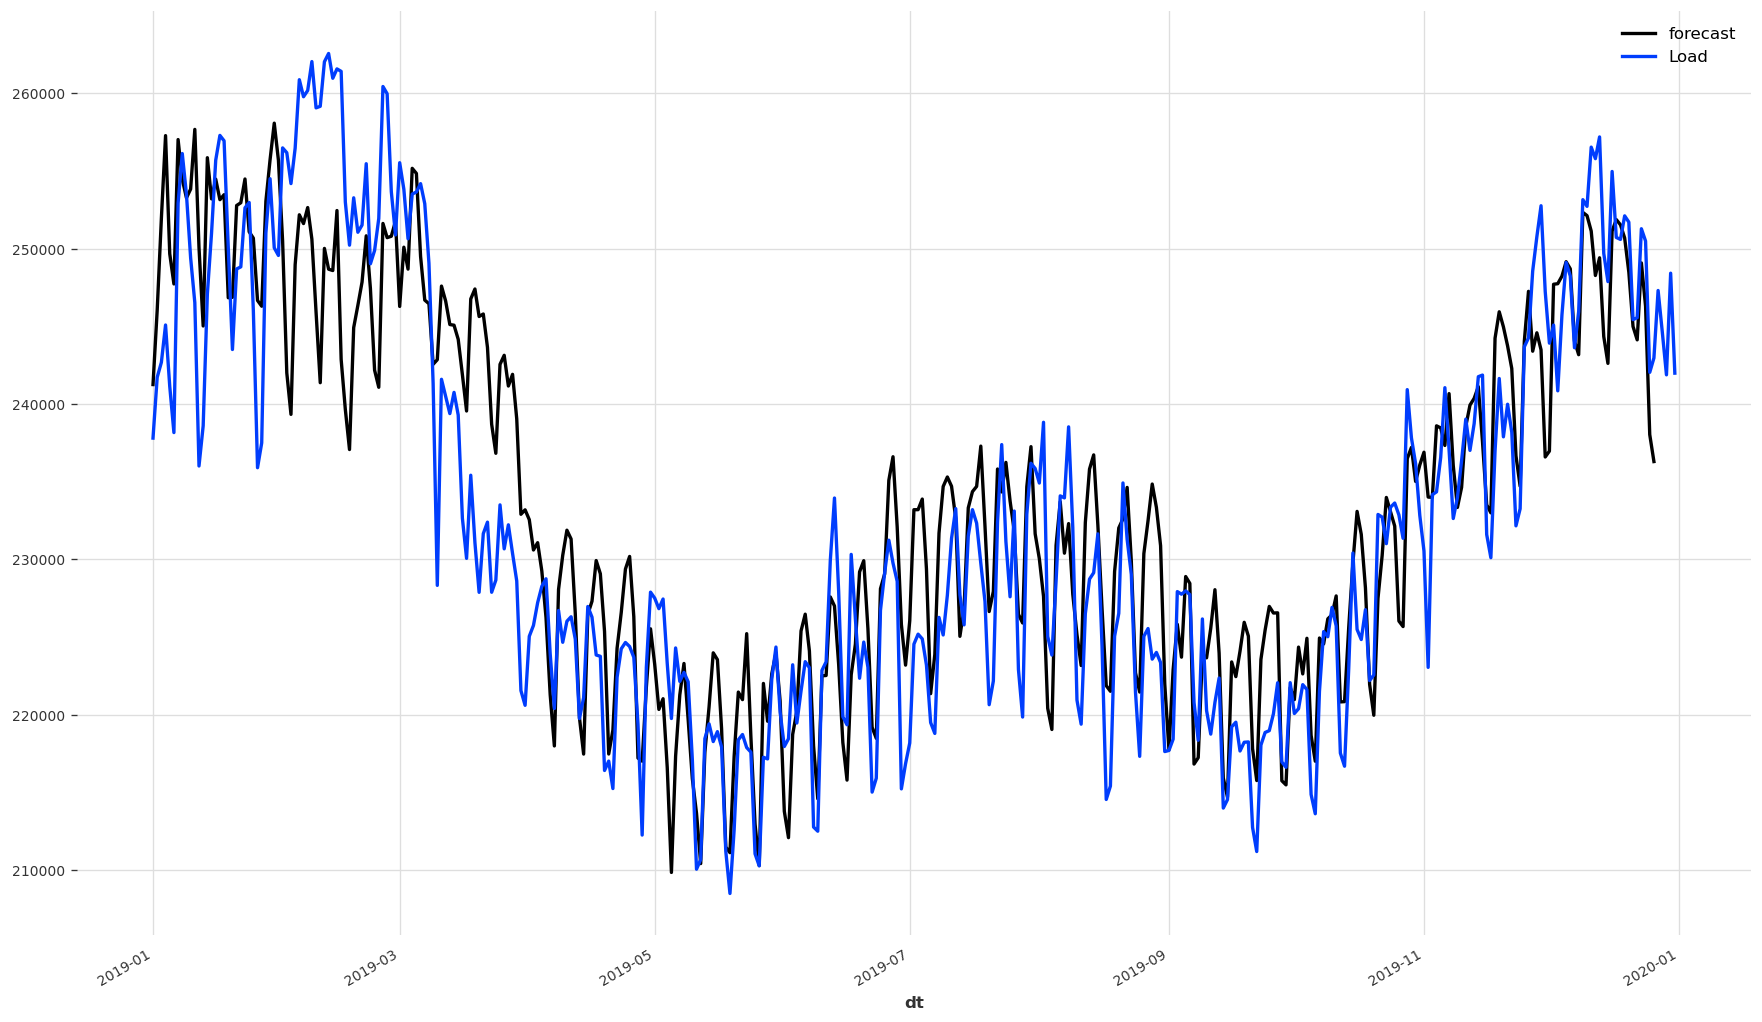

In [14]:
eval_results(deeptcn, past_covariates=covariates_scaled, future_covariates=None)

In [20]:
df_weather = pd.read_csv(r'weatherDaily.csv')
df_weather['Date'] = pd.to_datetime(df_weather['Date'])
Temp = TimeSeries.from_dataframe(df_weather, "Date",["MinTemp", "MaxTemp"])

Temp_scaled = Scaler(scaler_).fit_transform(Temp)
covariates_temp = covariates.stack(Temp_scaled).astype(np.float32)

In [40]:
input_chunk_length = 30
forecast_horizon = 1
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=3,
    #min_delta=0.05,
    #mode='min',
)

TFT = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=32,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=128,
    n_epochs=50,
    add_relative_index=False,
    add_encoders=None,
    #likelihood=QuantileRegression(
    #    quantiles=quantiles
    #),  # QuantileRegression is set per default
    loss_fn=MSELoss(),
    random_state=42,
    pl_trainer_kwargs= {"callbacks": [my_stopper]}

    )

TFT.fit(train_scaled, 
        past_covariates=covariates_temp,
        future_covariates=covariates_temp, 
        val_series=val_scaled,
        val_past_covariates=covariates_temp, 
        val_future_covariates=covariates_temp, 
        verbose=True)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/andreypak/opt/miniconda3/envs/electro2/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0     
1  | train_metrics                     | MetricCollection                 | 0     
2  | val_metrics                       | MetricCollection                 | 0     
3  | input_embeddings                  | _MultiEmbedding                  | 0     
4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
5  | enc

Epoch 14: 100%|██████████| 40/40 [02:26<00:00,  3.67s/it, train_loss=0.0404, val_loss=0.0769]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU avai

Average error (RMSE) over all historical forecasts: 4619.05


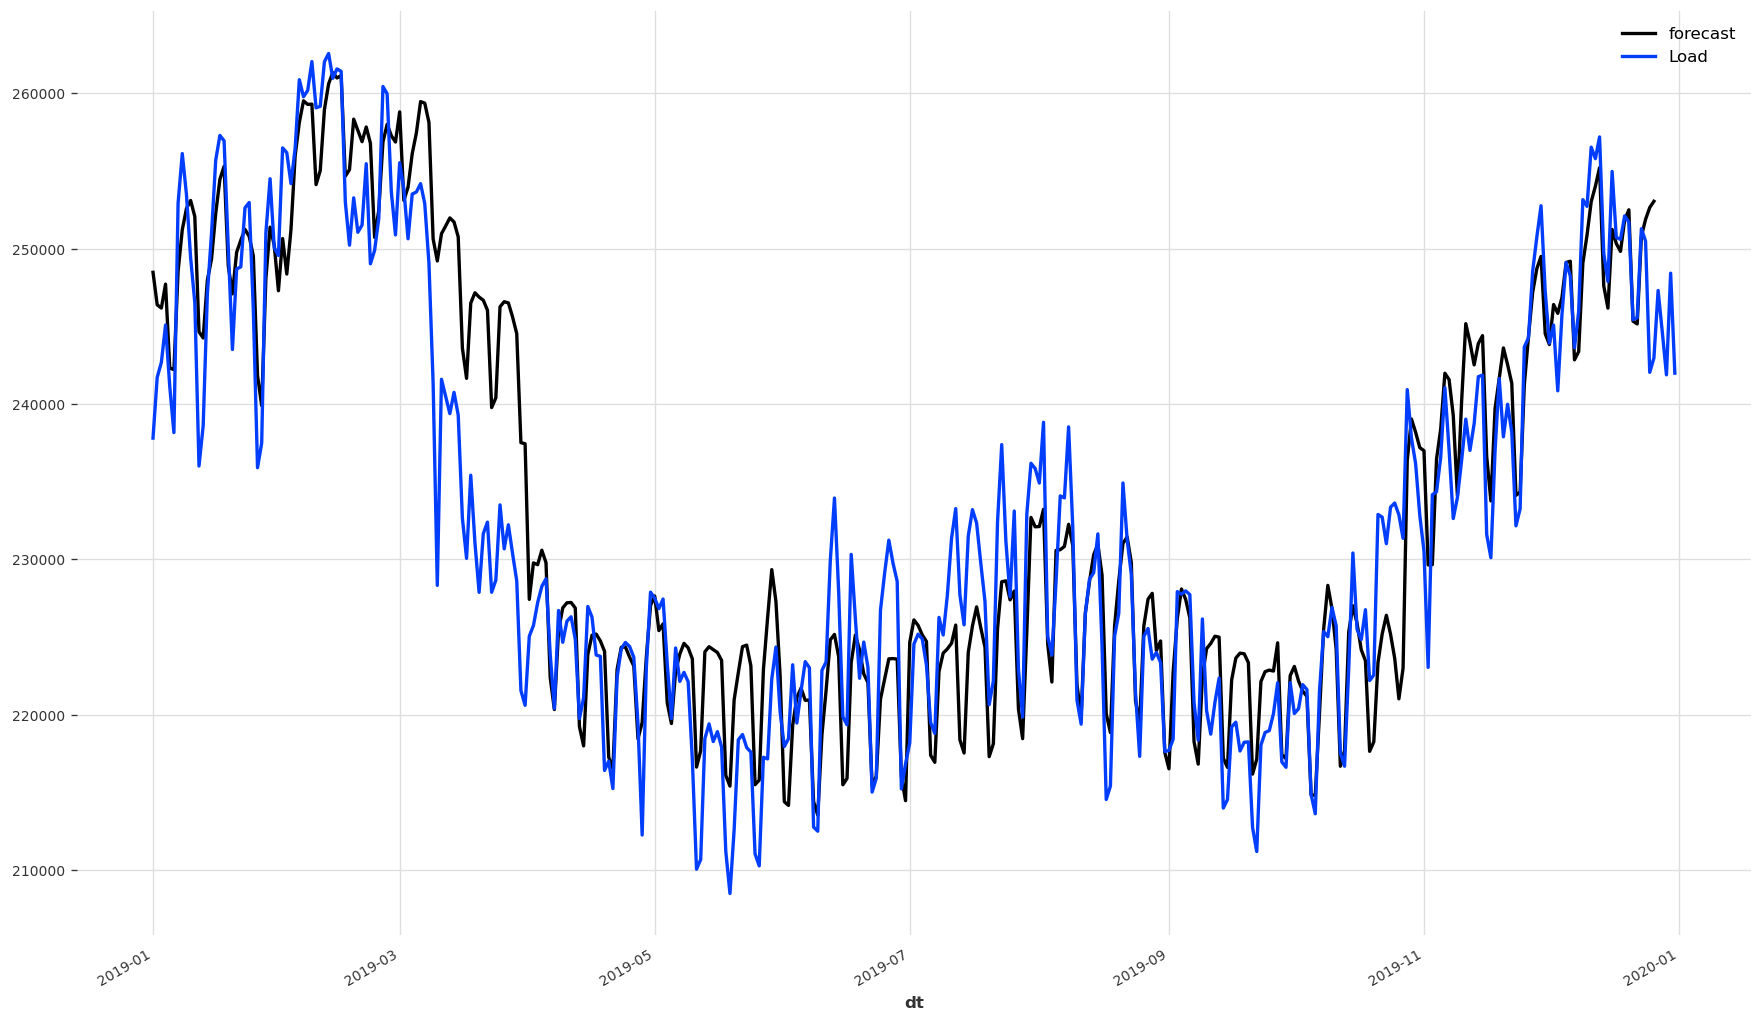

In [41]:
eval_results(TFT, covariates_temp, covariates_temp)